In [6]:
import LambdaRankHW
import numpy as np
import query
import os

In [24]:
train_queries = query.load_queries(os.path.normpath('./HP2003/Fold1/train.txt'), 64)
test_queries = query.load_queries(os.path.normpath('./HP2003/Fold1/test.txt'), 64)
val_queries = query.load_queries(os.path.normpath('./HP2003/Fold1/vali.txt'), 64)

loaded  0
loaded queries from file
loaded  0
loaded queries from file
loaded  0
loaded queries from file


In [6]:
print('training points', len(train_queries))
print('testing points', len(test_queries))
print('validation points', len(val_queries))

training points 90
testing points 30
validation points 30


In [7]:
num_docs = []
for query in train_queries:
    num_docs.append(query.get_document_count())

In [34]:
print(num_docs)

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 197, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [8]:
train_qids = set(train_queries.keys())
test_qids = set(test_queries.keys())
val_qids = set(val_queries.keys())
all_qids = set.union(train_qids, test_qids, val_qids) 

In [76]:
from operator import itemgetter
print(sorted(all_qids))

['152', '155', '158', '161', '162', '163', '166', '167', '168', '172', '174', '175', '176', '181', '183', '184', '186', '187', '192', '195', '199', '200', '201', '205', '208', '222', '226', '230', '233', '235', '238', '244', '245', '252', '254', '255', '257', '258', '260', '261', '262', '263', '265', '266', '267', '268', '269', '271', '273', '279', '280', '283', '284', '287', '288', '290', '291', '292', '294', '297', '299', '300', '302', '305', '307', '308', '309', '311', '313', '316', '317', '318', '319', '321', '322', '326', '328', '330', '332', '333', '334', '336', '337', '338', '339', '341', '343', '344', '346', '349', '350', '355', '356', '357', '361', '363', '364', '365', '367', '370', '371', '372', '374', '375', '376', '377', '378', '380', '381', '384', '385', '386', '387', '388', '389', '390', '392', '393', '394', '395', '396', '397', '398', '401', '403', '406', '407', '412', '414', '415', '418', '419', '420', '421', '422', '425', '429', '432', '433', '434', '435', '436', '437'

In [9]:
doc_ids = set()

for x in train_queries:
    doc_ids = set.union(set([doc.get_id() for doc in x.get_docids()]), doc_ids)
    
for x in test_queries:
    doc_ids = set.union(set([doc.get_id() for doc in x.get_docids()]), doc_ids)

for x in val_queries:
    doc_ids = set.union(set([doc.get_id() for doc in x.get_docids()]), doc_ids)

In [71]:
print(len(doc_ids))

1000


In [67]:
from scipy.sparse import dok_matrix

S = dok_matrix((1000,1000), dtype=np.float32)
q = train_queries['257']
ds = [doc.get_id() for doc in q.get_docids()]
labels = np.array(q.get_labels())
ones_idx = np.where(labels == 1)
nonones_idx = np.where(labels != 1)
for i in ones_idx:
    for j in nonones_idx:
        S[i,j] = 1

ValueError: shape mismatch: objects cannot be broadcast to a single shape

print(S.sum())
print(labels.sum())
print(q.get_qid())

In [38]:
np.where(np.array(q.get_labels()) == 1)

(array([5], dtype=int64),)

In [41]:
wins = list(S[5,:])
print(wins)

[<1x1000 sparse matrix of type '<class 'numpy.float32'>'
	with 999 stored elements in Dictionary Of Keys format>]


In [3]:
for i,v in S.items():
#     print(i,v)

SyntaxError: unexpected EOF while parsing (<ipython-input-3-69ed906a93b5>, line 2)

In [34]:
sum(train_queries['257'].get_labels())

2.0

In [106]:
q_d = {}

with open(os.path.normpath('./HP2003/Fold1/train.txt'),'r') as f:
    for line in f:
        a = line.split()
        qid = a[1].replace('qid:','')
        
        if qid not in q_d:
            q_d[qid] = set()
        
        q_d[qid].add(a[-1]) # add doc id

In [41]:
import importlib
importlib.reload(hw3_ref)
NUM_EPOCHS = 500

BATCH_SIZE = 1000
NUM_HIDDEN_UNITS = 100
LEARNING_RATE = 0.00005
MOMENTUM = 0.95

POINTWISE = 'pointwise'
PAIRWISE = 'pairwise'
LISTWISE = 'listwise'

n_epochs = 500
measure_type = POINTWISE
num_features = 64
num_folds = 2

res = hw3_ref.experiment(n_epochs, measure_type, num_features, num_folds)





Loading train queries
loaded  0
loaded queries from file

Loading val queries
loaded  0
loaded queries from file
Creating the S Matrix...
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 50 of 500 took 3.889s
training loss:		0.001582
val mNDCG:		0.638097

Epoch 100 of 500 took 3.930s
training loss:		0.001528
val mNDCG:		0.655496

Epoch 150 of 500 took 3.925s
training loss:		0.001566
val mNDCG:		0.658391

Epoch 200 of 500 took 4.000s
training loss:		0.001723
val mNDCG:		0.604693

Epoch 250 of 500 took 4.006s
training loss:		0.001443
val mNDCG:		0.645281

Epoch 300 of 500 took 3.796s
training loss:		0.001444
val mNDCG:		0.660911

Epoch 350 of 500 took 3.893s
training loss:		0.001472
val mNDCG:		0.660139

Epoch 400 of 500 took 3.826s
training loss:		0.001420
val mNDCG:		0.626510

Epoch 450 of 500 took 3.745s
training loss:		0.001403
val mNDCG:		0.646573

Epoch 500 of 500 took 3.839s
training loss:		0.001411
val mNDCG:		0.613760


Loading train queries
loaded  0
loaded queri

1
2


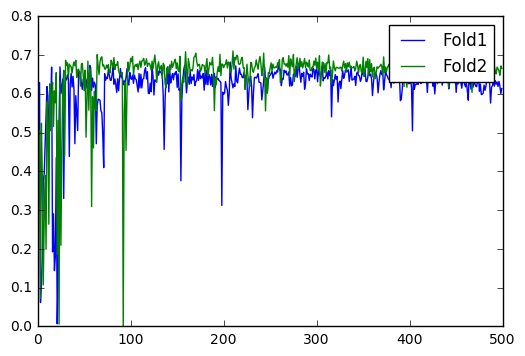

In [62]:
for i in res:
    print(i)


In [63]:
S


NameError: name 'S' is not defined